In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.layers import Dense
from keras.models import Sequential,Model

from tensorflow.keras.optimizers import Adam

In [2]:
class GaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if 1 or training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super(GaussianNoise, self).get_config()
        config.update({'stddev': self.stddev})
        return config
    
    
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        
        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega, shape):

    return tf.random.gamma(shape, m, 1/omega) ** 0.5
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=None):
        if  1 or training:
            # noise = tf.random.normal(tf.shape(inputs), **self.distribution_params)
            if tf.shape(inputs)[0] == None:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs))
            else:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs)[1:])
            return inputs * noise
        
        else:
            return inputs
        
        


class RicianFadingLayer(tf.keras.layers.Layer):
    def __init__(self, K, stddev, **kwargs):
        super(RicianFadingLayer, self).__init__(**kwargs)
        self.K = K  # Rician factor (K-factor)
        self.stddev = stddev  # Standard deviation of Rayleigh fading

    def call(self, inputs):
       
        rayleigh = tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
       
        LOS = tf.sqrt(self.K / (self.K + 1)) * tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
       
        rician = LOS + rayleigh
        
        return inputs * rician



In [3]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy


In [4]:
# generating the data set
k = 4
M = 2**k
NUM_CHANNEL_USES = 7

n_train = 10_000 * M

x_train = tf.random.uniform((n_train,),minval=0,maxval=2**k,dtype=tf.int32)
y_train = tf.expand_dims(x_train,axis=1)
x_train = tf.one_hot(x_train,depth=2**k)


In [5]:
y_train

<tf.Tensor: shape=(160000, 1), dtype=int32, numpy=
array([[12],
       [ 8],
       [ 5],
       ...,
       [ 8],
       [15],
       [ 5]])>

In [6]:

accuracies = []
while True:

        AE = Sequential([
            

                                Dense(2**k *2, activation='tanh',input_shape=(2**k,)),
                                Dense(2**k *2, activation='tanh'),

                                Dense(2*NUM_CHANNEL_USES, activation='linear'),
                                L2Normalization(name="normalization_layer"),


#                                 NakagamiNoiseLayer({"omega":1,"m":10}),
                                GaussianNoise(stddev=0.15,name="channel"),

#                                 L2Normalization(name="normalization_layer_at_rx"),

                                Dense(2**k, activation='tanh'),
                                Dense(2**k, activation='linear') # we are going to use SCCE from logits



                        ])

        AE.build()
        #     AE.summary()
        
        AE.compile(optimizer=Adam(learning_rate=1e-1),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
        AE.fit(x_train,y_train,epochs=10,)
        
        preds = np.argmax(AE.predict(x_train),axis=1,keepdims=1)
        accuracy = np.mean( preds == y_train  )
        print(f"accuracy = {accuracy}")
        
        accuracies.append(accuracy)
        if accuracy > 0.97 or len(accuracies)>=1:
            break
        
        
        
print("Accuracies: ", accuracies)

        

Epoch 1/10
5000/5000 [==============================] - 8s 1ms/step - loss: 0.0563
Epoch 2/10
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0485
Epoch 3/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0488
Epoch 4/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0872
Epoch 5/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0530
Epoch 6/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0514
Epoch 7/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0464
Epoch 8/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1126
Epoch 9/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0542
Epoch 10/10
5000/5000 [==============================] - 6s 1ms/step
accuracy = 0.99535
Accuracies:  [0.99535]


In [7]:


# bc = before_channel.predict(np.array([
#    [0,0,0],
#     [0,0,1],
#     [0,1,0],
#     [0,1,1],
#     [1,0,0],
#     [1,0,1],
#     [1,1,0],
#     [1,1,1],
    
  
  
    
# ]))



# bc = before_channel.predict(np.array([

#             [0,0,0,0],
#             [0,0,0,1],
#             [0,0,1,0],
#             [0,0,1,1],
#             [0,1,0,0],
#             [0,1,0,1],
#             [0,1,1,0],
#             [0,1,1,1],
#             [1,0,0,0],
#             [1,0,0,1],
#             [1,0,1,0],
#             [1,0,1,1],
#             [1,1,0,0],
#             [1,1,0,1],
#             [1,1,1,0],
#             [1,1,1,1]
    
# ]))




32/32 [==============================] - 0s 1ms/step


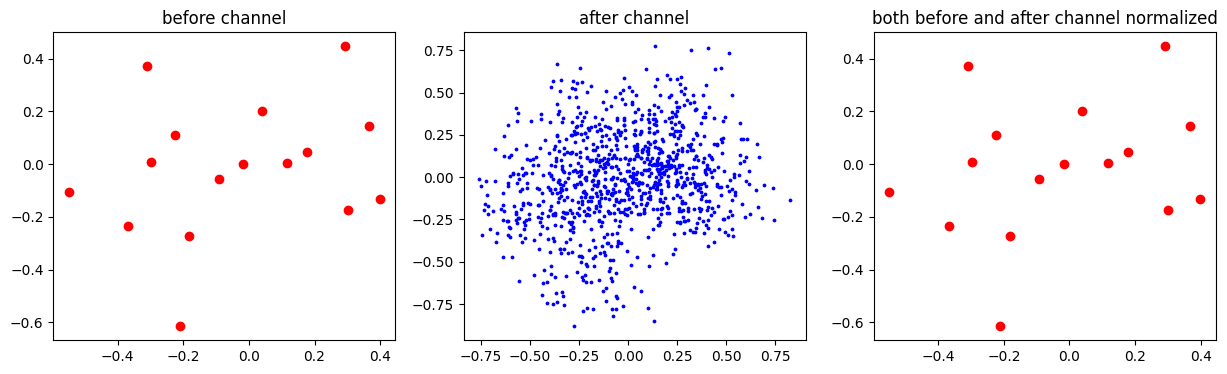

In [14]:


before_channel = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer').output)

after_channel  = Model(inputs=AE.input,
                                 outputs=AE.get_layer('channel').output)

#after_channel_normalized = Model(inputs=AE.input,
                                 #outputs=AE.get_layer('normalization_layer_at_rx').output)
    

    
allMsgInput = tf.one_hot(  np.arange(0,2**k,1).astype(np.int32)  ,depth=2**k)
# print("allMsgInput",allMsgInput)
bc = before_channel.predict(allMsgInput)
    


ac = after_channel.predict(x_train[:1000,:])
#acn = after_channel_normalized.predict(x_train[:500,:])


fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].scatter(bc[:,0],bc[:,1],c="red")
ax[0].set_title("before channel")


ax[1].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[1].set_title("after channel")


#ax[2].scatter(ac[:,0],acn[:,1],c="blue",s=3)
ax[2].scatter(bc[:,0],bc[:,1],c="red") # seconded to avoid occlusion
ax[2].set_title("both before and after channel normalized")


plt.show()

In [ ]:
bc.shape

In [ ]:



# # Example usage:
# m = 1.5  # Shape parameter
# omega = 2.0  # Scale parameter
# num_samples = 1000
# nakagami_samples = generate_nakagami_samples((None,num_samples,),m, omega)


# # Compute the histogram
# hist, bins = np.histogram(nakagami_samples, bins=20)  # Adjust the number of bins as needed

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(nakagami_samples, bins=20, color='blue', alpha=0.7)  # Plot the histogram bars
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Nakagami Samples')
# plt.grid(True)
# plt.show()

In [ ]:
bc

In [16]:
# saving AE to use in sequence decoder
savedir = r"D:\ENTC\PROJECTS\Deep-Learning-for-End-to-End-Over-the-Air-Communications\Fading - Nakagami Sumulation - Tensorflow\saved_encoders_for_Sequence_decoder"

required_encoder_wo_l2norm = Sequential(AE.layers[:3])

required_encoder_wo_l2norm.save(f'{savedir}\\r3ki3gEnc.h5')

